In [1]:
import pandas as pd
import SALib
from pathlib import Path
import os
import subprocess
import sys
import matplotlib.pyplot as plt

To view this notebook as slides, run `jupyter nbconvert examples/example.ipynb --to slides --post serve` on the command line

# ECEMP Skills Workshop: Global Sensitivity Analysis

- Will Usher, KTH Royal Institute of Technology
- Trevor Barnes, Simon Fraser University

# Introduction

# What is global sensitivity analysis?

- Global sensitivity analysis is “*the study of how uncertainty in the output of a model...can be apportioned to different sources of uncertainty in the model input*”. 
- “Global” means that all parameters are moved over their input ranges at the same time.
- By contrast, in one-at-a-time (OAT) sensitivity analysis, only one dimension of the model input space is explored while holding all other dimensions at their central value.
- An excellent introduction to global sensitivity analysis can be found in Saltelli (2007).

# Why perform global sensitivity analysis?

- Most energy system optimisation modelling studies use scenario analysis
- Global sensitivity analysis can supplement and support scenario analysis
  - identify key drivers of model results (factor prioritisation)
  - identify unimportant parameters (factor fixing)
  - identify interesting areas of the input space (factor mapping)

When models are used in a static manner, for example when influential parameters are held near a constant central value, these aspects of optimisation models – the apparent redundancy of parameters, lack of interaction effects and non-linear behaviour, may induce modellers to overlook parametric uncertainty. For example, modellers understandably tend to neglect the dimensions of the input space that are not represented in the results, resulting in parts of the model going “stale” as assumptions are not revisited or refreshed. On the other hand, modellers will commit a lot of attention to the parameters associated with technologies that do appear in the model results, even if those parameters are less influential than one of the static parameters.

## Methods for conducting global sensitivity analysis

Variance-based approaches compute the proportion of the variance in the output that is explained by variation in the input. 

- Computation of a first-order (only the direct effect) and total-order (direct and interaction effects) index for each input recovers all interaction and non-linear effects of a model. 
- Variance-based approaches require a relatively large number \$(500(k+2))\$ of model runs.

Elementary effects test, or “Method of Morris” lowers computationally needs \$(10(k+1))\$ by computing an average of local derivatives over a discrete space of input parameters.

- It provides an estimate for the total-order index produced by more advanced variance-based approaches 
- can be applied to groups of inputs to increase coverage and reduce computational demands.

# References

Andrea Saltelli, Marco Ratto, Terry Andres, Francesca Campolongo, Jessica Cariboni, Debora Gatelli, Michaela Saisana, and Stefano Tarantola. Global Sensitivity Analysis. The Primer. 1st ed. John Wiley & Sons, Ltd, 2007. https://doi.org/10.1002/9780470725184.


# Examples

## Example One

In this example, we will first show build a simple model and perform 
**LOCAL** sensitivity analysis

### Reference Energy System

Consider the simple energy system optimization model below. It includes:

- A mining technology for uranium
- A nuclear power generation technology
- Uranium fuel
- Electricity fuel

![RES](./assets/Example_One/RES.PNG)

### Input Data

Lets first create structural input data for the model

In [2]:
# REFERENCE ONLY. 
# DATA ALREADY CREATED. 
# DO NOT CHANGE
data_dir = Path('assets/Example_One/')

YEARS = range(2020, 2070)
TECHNOLOGIES = ['MINE_URANIUM', 'NUCLEAR']
FUELS = ['URANIUM', 'ELECTRICITY']
REGIONS = ['R1']
TIME_SLICE = ['S1D1', 'S1D2', 'S2D1', 'S2D2','S3D1','S3D2','S4D1','S4D2']
YEAR_SPLIT = 0.125
MODES = [1]

#### Add Capital Costs

In [3]:
def add_capex(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', years[0], cost]] * len(years), 
        columns=['REGION', 'TECHNOLOGY', 'YEAR', 'VALUE'])
    df['YEAR'] = years
    df.to_csv(Path(data_dir, 'data', 'CapitalCost.csv'), index=False)
    return df

In [4]:
capex = 4000 # M$ / GW
add_capex(capex).head()

FileNotFoundError: [Errno 2] No such file or directory: 'assets/Example_One/data/CapitalCost.csv'

#### Add Fixed Operational Costs

In [ ]:
def add_fixed(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', YEARS[0], cost]] * len(YEARS), 
        columns=['REGION', 'TECHNOLOGY', 'YEAR', 'VALUE'])
    df['YEAR'] = YEARS
    df.to_csv(Path(data_dir, 'data', 'FixedCost.csv'), index=False)
    return df

In [ ]:
fixed = 50 # M$ / GW
add_fixed(fixed).head()

#### Add Variable Costs

In [ ]:
def add_variable(cost):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'MINE_URANIUM', 1, years[0], cost]] * len(YEARS), 
        columns=['REGION','TECHNOLOGY','MODE_OF_OPERATION','YEAR','VALUE'])
    df['YEAR'] = YEARS
    df.to_csv(Path(data_dir, 'data', 'VariableCost.csv'), index=False)
    return df

In [5]:
variable = 2.5 # M$ / PJ
add_variable(variable).head()

NameError: name 'add_variable' is not defined

#### Add Nuclear Power Plant Efficiency 

In [6]:
def add_efficiency(eff):
    years = range(2020, 2070)
    df = pd.DataFrame(
        [['R1', 'NUCLEAR', 'URANIUM', 1, years[0], eff]] * len(years), 
        columns=['REGION','TECHNOLOGY','FUEL','MODE_OF_OPERATION','YEAR','VALUE'])
    df['YEAR'] = years
    df.to_csv(Path(data_dir, 'data', 'InputActivityRatio.csv'), index=False)
    return df

In [7]:
eff = 1.25 # 80 %
add_efficiency(eff).head()

FileNotFoundError: [Errno 2] No such file or directory: 'assets/Example_One/data/InputActivityRatio.csv'

#### Add Demand

In [8]:
def add_demand(start_value, yearly_increase):
    demand_data = []
    for year in range(2020, 2070):
        demand_data.append([
            'R1', 
            'ELECTRICITY',
            year,
            start_value*(1+yearly_increase)**(year-YEARS[0])
        ])
    df = pd.DataFrame(demand_data, columns=['REGION','FUEL','YEAR','VALUE'])
    df.to_csv(Path(data_dir, 'data', 'SpecifiedAnnualDemand.csv'), index=False)
    return df

In [9]:
start_value = 1000 # PJ
yearly_increase = 0.05 # %
add_demand(start_value, yearly_increase).head()

FileNotFoundError: [Errno 2] No such file or directory: 'assets/Example_One/data/SpecifiedAnnualDemand.csv'

#### Add Operational Life

In [10]:
def add_operational_life(op_life):
    df = pd.DataFrame([['R1','NUCLEAR',op_life]], columns=['REGION','TECHNOLOGY','VALUE'])
    df.to_csv(Path(data_dir, 'data', 'OperationalLife.csv'), index=False)
    return df

In [11]:
op_life = 50 # years
add_operational_life(op_life).head()

FileNotFoundError: [Errno 2] No such file or directory: 'assets/Example_One/data/OperationalLife.csv'

### One-at-a-time Sensitivity Analysis

Run the model with the baseline input parameters and get a reference objective value

In [12]:
def run_model(path_to_data_dir, path_to_model_file, result_file_name):
    os.system(
        'otoole convert datapackage datafile {} {}' .format(
            Path(path_to_data_dir,'datapackage.json'), 
            Path(path_to_data_dir,'data.txt')
        )
    )
    os.system(
        'glpsol -m {} -d {} --wlp {} --check' .format(
            Path(path_to_model_file),
            Path(path_to_data_dir,'data.txt'),
            Path(path_to_data_dir,'model.lp'),
        )
    )
    os.system(
        'cbc {} solve -solu {}' .format(
            Path(path_to_data_dir,'model.lp'),
            Path(path_to_data_dir,result_file_name)
        )
    )

def get_objective_value(result_files):
    for result_file in result_files:
        print(f'{result_file.name}')
        os.system('head -1 {}' .format(Path(result_file)))

In [44]:
run_model(data_dir, '../resources/osemosys.txt', 'baseline.txt')
get_objective_value([Path(data_dir, 'baseline.txt')])

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --wlp assets/Example_One/model.lp
 --check
Reading model section from ../resources/osemosys.txt...
1425 lines were read
Reading data section from assets/Example_One/data.txt...
1365 lines were read
Checking Max and Min capcity-investment bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 175)...
Checking Annual activity limits for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 180)...
Checking Residual and TotalAnnualMax Capacity for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 185)...
Checking Residual, Total annual maxcap and mincap investments for  all Region, Tech and Year 
Checking (line 190)...
Checking Annual production by technology bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 195)...
Checking TimeSlices/YearSplits for y in YEAR 
Checking (line 200)...
Checking (line 201)...
Checking 

Now that we have got a basline objective value ($572721), we would choose a parmaeter to alter a few times to understand how it effects the overall objective value

In [45]:
result_files = []

# Iterate over capital cost
capital_costs = [2500, 3000, 3500, 4500, 5000]
for capital_cost in capital_costs:
    add_capex(capital_cost)
    result_file = f'capex_{capital_cost}.txt'
    result_files.append(Path(data_dir, result_file))
    run_model(data_dir, '../resources/osemosys.txt', result_file)

# resest to origianl capital cost
add_capex(4000)

# Iterate over variable cost
var_costs = [1.5, 2.0, 3.0, 3.5, 4.0]
for var_cost in var_costs:
    add_variable(var_cost)
    result_file = f'var_cost_{var_cost}.txt'
    result_files.append(Path(data_dir, result_file))
    run_model(data_dir, '../resources/osemosys.txt', result_file)

# reset to original variable cost
add_variable(2.5)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --wlp assets/Example_One/model.lp
 --check
Reading model section from ../resources/osemosys.txt...
1425 lines were read
Reading data section from assets/Example_One/data.txt...
1365 lines were read
Checking Max and Min capcity-investment bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 175)...
Checking Annual activity limits for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 180)...
Checking Residual and TotalAnnualMax Capacity for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 185)...
Checking Residual, Total annual maxcap and mincap investments for  all Region, Tech and Year 
Checking (line 190)...
Checking Annual production by technology bounds for r in REGION, t in TECHNOLOGY, y in YEAR 
Checking (line 195)...
Checking TimeSlices/YearSplits for y in YEAR 
Checking (line 200)...
Checking (line 201)...
Checking 

58201 lines were written
--- Problem Characteristics ---
Number of rows               =    16684
Number of columns            =    17217
Number of non-zeros (matrix) =    41366
Number of non-zeros (objrow) =       51
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc assets/Example_One/model.lp solve -solu assets/Example_One/capex_3000.txt (default strategy 1)
Presolve 49 (-16634) rows, 99 (-17118) columns and 1323 (-39992) elements
0  Obj 331276.6 Primal inf 5052.8928 (49)
49  Obj 488577.91
Optimal - objective value 488577.91
After Postsolve, objective 488577.91, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 488577.9105 - 49 iterations time 0.022, Presolve 0.02
Total time (CPU seconds):       0.12   (Wallclock seconds):       0.15

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --wlp assets/Example_One/model.lp
 --check
Reading model sec

58201 lines were written
--- Problem Characteristics ---
Number of rows               =    16684
Number of columns            =    17217
Number of non-zeros (matrix) =    41366
Number of non-zeros (objrow) =       51
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc assets/Example_One/model.lp solve -solu assets/Example_One/capex_4500.txt (default strategy 1)
Presolve 49 (-16634) rows, 99 (-17118) columns and 1323 (-39992) elements
0  Obj 378841.28 Primal inf 5052.8928 (49)
49  Obj 614793.26
Optimal - objective value 614793.26
After Postsolve, objective 614793.26, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 614793.2557 - 49 iterations time 0.032, Presolve 0.02
Total time (CPU seconds):       0.13   (Wallclock seconds):       0.16

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --wlp assets/Example_One/model.lp
 --check
Reading model se

58201 lines were written
--- Problem Characteristics ---
Number of rows               =    16684
Number of columns            =    17217
Number of non-zeros (matrix) =    41366
Number of non-zeros (objrow) =       51
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc assets/Example_One/model.lp solve -solu assets/Example_One/var_cost_1.5.txt (default strategy 1)
Presolve 49 (-16634) rows, 99 (-17118) columns and 1323 (-39992) elements
0  Obj 301992.62 Primal inf 5052.8928 (49)
49  Obj 511727.7
Optimal - objective value 511727.7
After Postsolve, objective 511727.7, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 511727.7018 - 49 iterations time 0.022, Presolve 0.02
Total time (CPU seconds):       0.13   (Wallclock seconds):       0.15

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --wlp assets/Example_One/model.lp
 --check
Reading model sec

Writing problem data to 'assets/Example_One/model.lp'...
58201 lines were written
--- Problem Characteristics ---
Number of rows               =    16684
Number of columns            =    17217
Number of non-zeros (matrix) =    41366
Number of non-zeros (objrow) =       51
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc assets/Example_One/model.lp solve -solu assets/Example_One/var_cost_3.0.txt (default strategy 1)
Presolve 49 (-16634) rows, 99 (-17118) columns and 1323 (-39992) elements
0  Obj 393483.27 Primal inf 5052.8928 (49)
49  Obj 603218.36
Optimal - objective value 603218.36
After Postsolve, objective 603218.36, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 603218.36 - 49 iterations time 0.022, Presolve 0.02
Total time (CPU seconds):       0.12   (Wallclock seconds):       0.15

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 -m ../resources/osemosys.txt -d assets/Example_One/data.txt --

Writing problem data to 'assets/Example_One/model.lp'...
58201 lines were written
--- Problem Characteristics ---
Number of rows               =    16684
Number of columns            =    17217
Number of non-zeros (matrix) =    41366
Number of non-zeros (objrow) =       51
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc assets/Example_One/model.lp solve -solu assets/Example_One/var_cost_4.0.txt (default strategy 1)
Presolve 49 (-16634) rows, 99 (-17118) columns and 1323 (-39992) elements
0  Obj 454477.05 Primal inf 5052.8928 (49)
49  Obj 664212.13
Optimal - objective value 664212.13
After Postsolve, objective 664212.13, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 664212.1321 - 49 iterations time 0.022, Presolve 0.02
Total time (CPU seconds):       0.13   (Wallclock seconds):       0.15



,REGION,TECHNOLOGY,MODE_OF_OPERATION,YEAR,VALUE
0,R1,MINE_URANIUM,1,2020,2.5
1,R1,MINE_URANIUM,1,2021,2.5
2,R1,MINE_URANIUM,1,2022,2.5
3,R1,MINE_URANIUM,1,2023,2.5
4,R1,MINE_URANIUM,1,2024,2.5
5,R1,MINE_URANIUM,1,2025,2.5
6,R1,MINE_URANIUM,1,2026,2.5
7,R1,MINE_URANIUM,1,2027,2.5
8,R1,MINE_URANIUM,1,2028,2.5
9,R1,MINE_URANIUM,1,2029,2.5


In [47]:
get_objective_value(result_files)

capex_2500.txt
Optimal - objective value 446506.12875852
capex_3000.txt
Optimal - objective value 488577.91048683
capex_3500.txt
Optimal - objective value 530649.69221515
capex_4500.txt
Optimal - objective value 614793.25567179
capex_5000.txt
Optimal - objective value 656865.03740011
var_cost_1.5.txt
Optimal - objective value 511727.70183624
var_cost_2.0.txt
Optimal - objective value 542224.58788985
var_cost_3.0.txt
Optimal - objective value 603218.35999709
var_cost_3.5.txt
Optimal - objective value 633715.24605071
var_cost_4.0.txt
Optimal - objective value 664212.13210432


Create simple plots to see how the costs change with parameters

<AxesSubplot:title={'center':'Effects of Variable Cost'}, xlabel='Variable Cost (M$/PJ)', ylabel='Objective Cost (M$)'>

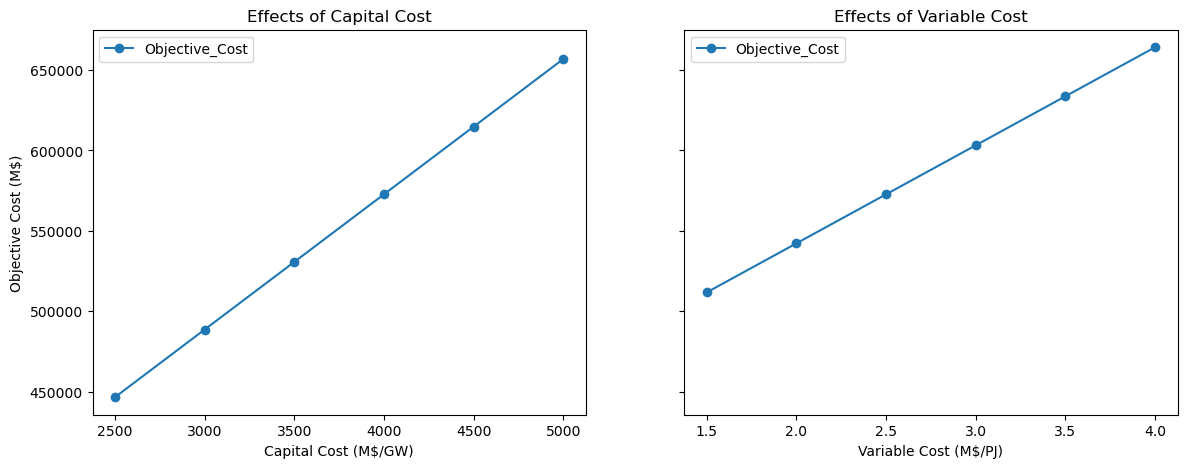

In [48]:
df_capex = pd.DataFrame([
    [2500, 446506],
    [3000, 488577],
    [3500, 530649],
    [4000, 572721],
    [4500, 614793],
    [5000, 656865],
], columns=['Capex', 'Objective_Cost']).set_index('Capex')

df_var = pd.DataFrame([
    [1.5, 511727],
    [2.0, 542224],
    [2.5, 572721],
    [3.0, 603218],
    [3.5, 633715],
    [4.0, 664212],
], columns=['Var_Cost', 'Objective_Cost']).set_index('Var_Cost')

fig, axs = plt.subplots(1,2, figsize=(14,5), sharey=True)
df_capex.plot(ax=axs[0], marker='o', title='Effects of Capital Cost', xlabel='Capital Cost (M$/GW)', ylabel='Objective Cost (M$)')
df_var.plot(ax=axs[1], marker='o', title='Effects of Variable Cost', xlabel='Variable Cost (M$/PJ)', ylabel='Objective Cost (M$)')

### Problems with local sensitivity analysis

- Does not capture interactions
- Difficult to understand what parameter is more influential on results

## Example Two 

We will repeat example one, except employ **GLOBAL** sensitivity analysis using
the Method of Morris. This will be done through an automated workflow. 

### Reference Energy Systen

Our RES remains the same. It includes:
- A mining technology for uranium
- A nuclear power generation technology
- Uranium fuel
- Electricity fuel

![RES](examples/assets/Example_One/RES.PNG)

## Introduce the workflow

1. Update config files
2. Run the workflow
3. Assess results

### Update a configuration files

Navigate to `config/scenarios.csv` file and update it to match the following:


| name | description      | path                             |
|------|------------------|----------------------------------|
|0     | "Simple Example" | examples/assets/datapackage.json |

Navigate to [`config/parameters.csv`](../edit/config/parameters.csv) file and update it to match the following:

|name |group|indexes|min_value_base_year|max_value_base_year|min_value_end_year|max_value_end_year|dist|interpolation_index|action|
|-----|-----|-------|-------------------|-------------------|------------------|------------------|----|-------------------|------|
|CapitalCost  |capital  |"R1,NUCLEAR"        |4000 |5000 |2000 |3000 |"unif" |"YEAR" |"interpolate" |
|VariableCost |variable |"R1,MINE_URANIUM,1" |3.5  |4.0  |1.5  |1.75 |"unif" |"YEAR" |"interpolate" |

In this table, we are specifying one of these three different methods for interpolating values over time. 

![GSA_options](examples/assets/Example_One/GSA_options.PNG)

### Run the Workflow

In [52]:
def clean_snakemake():
    wd = sys.path[0]
    os.chdir(wd)
    subprocess.Popen("snakemake --cores 4 clean", cwd="..", shell=True)
def run_snakemake():
    wd = sys.path[0]
    os.chdir(wd)
    subprocess.Popen("snakemake --cores 4", cwd="..", shell=True)

clean_snakemake()
run_snakemake()

KeyError in line 18 of /Users/wusher/repository/gui_workflow/workflow/Snakefile:
'zip'
  File "/Users/wusher/repository/gui_workflow/workflow/Snakefile", line 18, in <module>
KeyError in line 18 of /Users/wusher/repository/gui_workflow/workflow/Snakefile:
'zip'
  File "/Users/wusher/repository/gui_workflow/workflow/Snakefile", line 18, in <module>


In [19]:
!snakemake --cores 4

Building DAG of jobs...
WorkflowError:
MissingInputException: Missing input files for rule unzip_solution:
temp/0/model_0.sol.gz
WorkflowError:
    MissingInputException: Missing input files for rule copy_datapackage:
    examples/assets/datapackage.json
    MissingInputException: Missing input files for rule unzip:
    temp/0/model_0.lp.gz


In [13]:
!ls


LICENSE            config             gurobi.log         requirements.txt
README.md          dashboard          model              resources
Tutorial.ipynb     deploy.sh          modelruns          results
Untitled.ipynb     examples           my_profile.py      workflow
Vagrantfile        ff_sample.txt      param_file.txt
__pycache__        gsa.code-workspace pdc
benchmarks         gui.code-workspace processed_data
